In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import GridSearchCV

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Загружаем данные

In [3]:
X_test = pd.read_csv('test.csv')

In [4]:
X_test.head()

,oid,text
0,749208109,СПОЧНО СООБЩЕСТВО ПРОДАЕТСЯ ЗА 1300Р ЗА ПОКУПК...
1,452466036,Естественное восстановление после тяжелой трен...
2,161038103,Тема нарядов продолжается Одна из британских ж...
3,663621910,Привет Избранный. Ты спрашиваешь себя ЧТО здес...
4,566255305,КОРОЛЬ ПЯТИСОТНИКОВ В ДЕЛЕ Андрей Рублев успеш...


In [5]:
sample_submission = pd.read_csv('sample_submission.csv')

In [6]:
sample_submission.head()

,oid,category
0,1622114,athletics
1,1663817,autosport
2,3174332,basketball
3,3469228,extreme
4,3905302,boardgames


In [7]:
train_file = pd.read_csv('train.csv')

In [8]:
train_file.head()

,oid,category,text
0,365271984,winter_sport,Волшебные фото Виктория Поплавская ЕвгенияМедв...
1,503385563,extreme,Возвращение в подземелье Треша 33 Эйфория тупо...
2,146016084,football,Лучшие чешские вратари – Доминик Доминатор Гаш...
3,933865449,boardgames,Rtokenoid Warhammer40k валрак решил нас подкор...
4,713550145,hockey,Шестеркин затаскивает Рейнджерс в финал Восточ...


In [9]:
target = train_file['category']

In [10]:
data = train_file.drop('category', axis=1)

#### Обрабатываем текст постов. Делаем его строчным

In [11]:
X_test['text'] = X_test['text'].str.lower()

In [12]:
data['text'] = data['text'].str.lower()

### Создаем bag-of-words с помощью CountVectorizer

In [13]:
cv = CountVectorizer()
cv.fit(data['text'])
len(cv.vocabulary_)

146608

In [14]:
print(cv.get_feature_names()[50000:50050])

['инсталляциями', 'инстанции', 'инстанция', 'инстасторис', 'инсте', 'инстинкт', 'инстинкта', 'инстинктах', 'инстинкте', 'инстинктивно', 'инстинктивное', 'институт', 'института', 'институте', 'институтов', 'институтом', 'институту', 'институты', 'инструктируем', 'инструктор', 'инструктора', 'инструкторами', 'инструкторов', 'инструктором', 'инструкторские', 'инструктору', 'инструкторы', 'инструкцией', 'инструкции', 'инструкций', 'инструкцию', 'инструкция', 'инструкциям', 'инструкциями', 'инструмент', 'инструмента', 'инструментальный', 'инструментам', 'инструментарий', 'инструментах', 'инструменте', 'инструментов', 'инструментом', 'инструменты', 'инсту', 'инсты', 'инсулиноподобный', 'инсулину', 'инсульт', 'инсульта']


In [15]:
data_transform = cv.transform(data['text'])

In [16]:
test_transform = cv.transform(X_test['text'])

### Train Test Split

In [17]:
X_train, X_val, y_train, y_val = train_test_split(data_transform, target, test_size=0.30, random_state=0)

## Logistic Regression

In [18]:
logit = LogisticRegression(n_jobs=-1, random_state=7)

In [19]:
logit.fit(X_train, y_train)

LogisticRegression(n_jobs=-1, random_state=7)

In [20]:
round(logit.score(X_train, y_train), 3) # Train score

0.994

In [21]:
round(logit.score(X_val, y_val), 3) # Val score

0.824

### Воспользуемся кривыми обучения и валидации для нахождения лучшего значения C

In [22]:
val_curve_train, val_curve_test = validation_curve(
    estimator=logit, X=data_transform, y=target, param_name="C", param_range=[0.3, 0.6, 1, 3], cv=3, n_jobs=-1
)

In [23]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, "-", **kwargs)
    plt.fill_between(
        x,
        mu - std,
        mu + std,
        edgecolor="none",
        facecolor=lines[0].get_color(),
        alpha=0.2,
    )

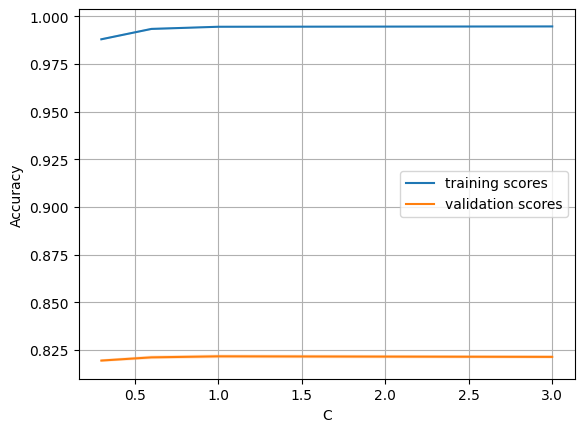

In [24]:
plot_with_err([0.3, 0.6, 1, 3], val_curve_train, label="training scores")
plot_with_err([0.3, 0.6, 1, 3], val_curve_test, label="validation scores")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True);

#### Вывод: Стандартное значение C = 1.0 является оптимальным

### Для модели Logistic Regression получили 0.824 val accuracy  и 0.994 train accuracy. Модель сильно переобучена

## Random Forest

In [22]:
rf_plain = RandomForestClassifier(random_state=0, n_jobs=-1, verbose=1)

In [28]:
rf_plain.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.7min finished
  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

In [29]:
round(rf_plain.score(X_train, y_train), 3) # Train score

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.9s finished


0.995

In [30]:
round(rf_plain.score(X_val, y_val), 3) # Val score

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.7s finished


0.79

### Random Forest с параметрами по умолчанию сильно переобучается: 0.995 train, 0.79 val

### Подберем оптимальные параметры с помощью GridSearchCV

In [23]:
rf_params = {'max_depth': [5, 50, 100], 'n_estimators': [10, 200]}

In [24]:
rf_search = GridSearchCV(estimator=rf_plain, param_grid=rf_params, cv=3,
                         n_jobs=3, verbose=1, scoring='accuracy', return_train_score=True)

In [25]:
rf_search.fit(data_transform, target)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.6min finished


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=0,
                                              verbose=1),
             n_jobs=3,
             param_grid={'max_depth': [5, 50, 100], 'n_estimators': [10, 200]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [26]:
rf_search.best_estimator_

RandomForestClassifier(max_depth=100, n_estimators=200, n_jobs=-1,
                       random_state=0, verbose=1)

In [27]:
rf_search.best_score_

0.7537170593017671

In [35]:
rf_search.cv_results_['mean_train_score']

array([0.23296349, 0.54488899, 0.64925144, 0.82438048, 0.79819302,
       0.90538205])

In [36]:
rf_search.cv_results_['mean_test_score']

array([0.23100124, 0.53082094, 0.56055754, 0.71726895, 0.63562227,
       0.75371706])

### Random forest в лучшем случае имеет accuracy 0.75 на валидации

## Gradient Boosting

In [20]:
plain_boost = GradientBoostingClassifier(random_state=0, verbose=1, n_estimators=20, learning_rate=0.5)

In [21]:
plain_boost.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.8659           21.21m
         2           1.6362           19.80m
         3           1.4832           18.62m
         4           1.3826           17.37m
         5           1.3044           16.23m
         6           1.2394           15.09m
         7           1.1839           14.07m
         8           1.1364           13.02m
         9           1.0986           11.91m
        10           1.0640           10.83m
        20 17912683369.1064            0.00s


GradientBoostingClassifier(learning_rate=0.5, n_estimators=20, random_state=0,
                           verbose=1)

In [22]:
plain_boost.score(X_train, y_train) # Train score

0.7443764289401873

In [23]:
plain_boost.score(X_val, y_val) # Val score

0.6948029599036311

### С Gradient Boosting получили низкий accuaracy: val sсore 0.69 при train score 0.74

## Submission

Лучший accuracy показала Logistic Regression. На public тесте лучший результат тоже у неё

In [37]:
logit_pred = logit.predict(test_transform)

Перед тем, как сделать submit предсказаний на тестовой выборке, стоит учесть метрику соревнования

+1 балл дается за правильную классификацию, -1 балл за неправильную. Таким образом будет разумно рассмотреть полученные predict_proba, и оставить только те записи, для которых предсказание имеет достаточно большую вероятность

Перебором был найден наиболее эффективный вариант: оставить только предсказания с вероятностью >= 0.7

In [40]:
logit_pred_probs = pd.DataFrame(logit.predict_proba(test_transform))

In [41]:
logit_pred_probs.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.012276,0.049819,0.021695,0.001875,0.649215,0.030108,0.111271,0.013530,0.052015,0.020509,0.009361,0.013870,0.014454
1,0.011517,0.549002,0.003323,0.000431,0.148016,0.005337,0.092526,0.002513,0.012590,0.000613,0.000459,0.151639,0.022036
2,0.002656,0.010196,0.011682,0.038773,0.061675,0.067349,0.003932,0.009821,0.008354,0.082984,0.658152,0.005639,0.038785
3,0.002455,0.007129,0.000316,0.013619,0.820096,0.148920,0.000131,0.000054,0.000476,0.000953,0.002519,0.003319,0.000014
4,0.001913,0.018877,0.002008,0.002322,0.003061,0.006306,0.012295,0.003445,0.004969,0.002966,0.926819,0.002106,0.012914


In [42]:
logit_prob_values = pd.DataFrame([max(i) for i in logit_pred_probs.values])

In [43]:
logit_prob_values.head()

,0
0,0.649215
1,0.549002
2,0.658152
3,0.820096
4,0.926819


In [46]:
sample_submission.head()

,oid,category
0,1622114,athletics
1,1663817,autosport
2,3174332,basketball
3,3469228,extreme
4,3905302,boardgames


In [44]:
sub = X_test.copy()

In [45]:
sub.head()

,oid,text
0,749208109,спочно сообщество продается за 1300р за покупк...
1,452466036,естественное восстановление после тяжелой трен...
2,161038103,тема нарядов продолжается одна из британских ж...
3,663621910,привет избранный. ты спрашиваешь себя что здес...
4,566255305,король пятисотников в деле андрей рублев успеш...


In [47]:
sub = sub.drop('text', axis=1)

In [48]:
sub['category'] = logit_pred

In [49]:
sub['prob'] = logit_prob_values

In [50]:
sub.head()

,oid,category,prob
0,749208109,esport,0.649215
1,452466036,autosport,0.549002
2,161038103,tennis,0.658152
3,663621910,esport,0.820096
4,566255305,tennis,0.926819


In [51]:
sub = sub[sub.prob >= 0.7]

In [52]:
sub = sub.drop('prob', axis=1)

In [53]:
sub.head()

,oid,category
3,663621910,esport
4,566255305,tennis
5,332983824,volleyball
7,770457906,volleyball
8,720955404,boardgames


In [54]:
sub.to_csv('logit_07.csv')